## Spatially Mapping Bipolar ECL Microelectrode Array Data using Python & ImageJ

### *Peter Defnet*
*Up to date as of August 18, 2020*

### *Part 1: ImageJ Macro Langugae Script*

The ImageJ macro produces a thresholded image of the array. This will serve as the template for which values are mapped to in Python, and therefore it is critical that the product looks uniform, and representative of the original array.

We start by setting up local variables to enable automatic saving, used later in the script. Filename_load is simply the name of the tiff stack as a string, and file_extension is the path where the results will be saved. The specific path for the thresholded image (.tif) and results (.txt) are defined as well.

In [4]:
## (ImageJ Macro Language)
#Filename_load = "ECL-CV Example Data"
#file_extension = "E:/Data/ProgramOutput/" + Filename_load + "/" // extenstion for mkdir

#File.makeDirectory(file_extension) 
#Save_threshold = file_extension + "thresh_" + Filename_load + ".tif"
#Save_results = file_extension + "Results_" + Filename_load + ".txt"


The general strategy will be to average the pixel intensities across 200 non-light producing frames (typically found at the start of the video). This produces a sufficient-resolution image clearly showing the array’s structure. This image is then inverted to make the electrodes white with a dark background, converted to 8-bit, and then locally thresholded. Figure 2 displays this process.

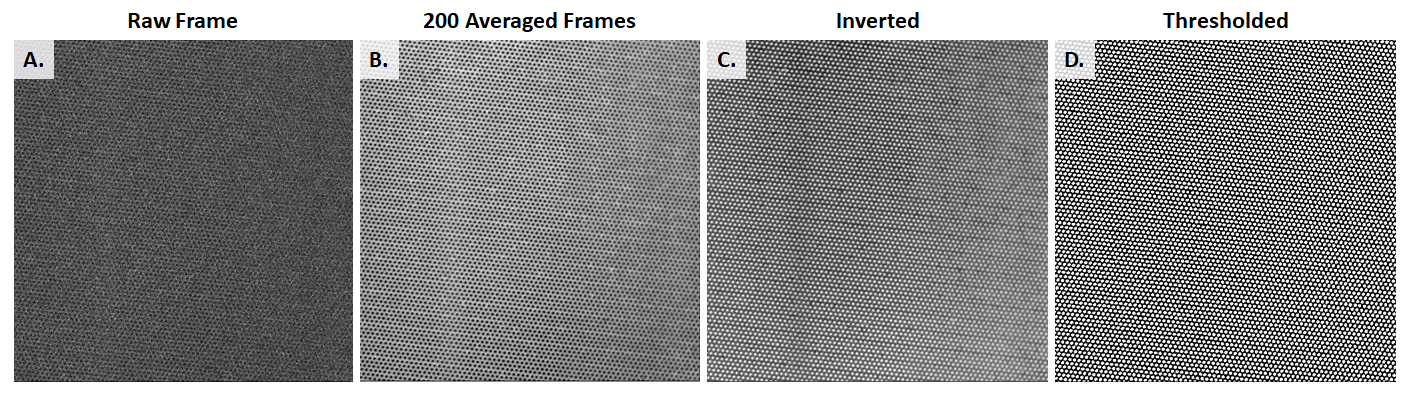

In [9]:
from IPython.display import Image
Image(filename='E:/Data/Figure 2 png.png') 

In [6]:
#selectWindow(Filename_load + ".tif");
#run("Duplicate...", "duplicate range=1-200");
#run("Z Project...", "projection=[Average Intensity]");
#run("Invert");
#run("8-bit");
#run("Auto Local Threshold", "method=Median radius=5 parameter_1=0 parameter_2=0 white");

The quality of the thresholded image is then improved by ensuring each electrode is separate from its neighbors (i.e. pixels are not connecting) with the “Watershed” method, and fill any holes produced during thresholding with the “Fill Holes” method. The thresholded image is then saved, and later used in Python.

In [7]:
#run("Options...", "iterations=1 count=1 black do=Nothing"); //white objects black background
#run("Watershed"); //separate particles connected by corners
#run("Fill Holes"); // fill holes in roi's
#run("Watershed"); // Be sure that they are separated. 
#saveAs("Tiff", Save_threshold);

The ROI’s are then identified from the thresholded image, applied to our (1500 frame) tiff stack, and the intensity-time data is extracted from each respective electrode position. The data is saved for later analysis in Python.

In [8]:
#run("Analyze Particles...", "size=5-Infinity display clear add");
#run("Set Measurements...", "mean centroid area_fraction stack display redirect=None decimal=3");
#roiManager("Associate", "false");
#roiManager("Centered", "false");
#roiManager("UseNames", "true");
#selectWindow(Filename_load + ".tif");
#roiManager("multi-measure measure_all");
#saveAs("Results", Save_results);

### *Part 2:  Python Analysis:*

In Python, we import both the thresholded image, and results data from the folders from which they were saved in Imagej. Note that filename_load and file_extension are defined identically as they were in imagej, and represent the only inputs for this program.

In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io, measure

filename_load = "ECL-CV Example Data" #number on thresh, results files. 
file_extension = "E:/Data/ProgramOutput/"

#Load Thresholded Image
img = io.imread(file_extension + str(filename_load) + '/' + 'thresh_' + str(filename_load) + '.tif')

#Import ROI results df #Saved results in imagej from ROI manager. 
res = pd.read_csv(file_extension + str(filename_load) + '/' + 'Results_' + str(filename_load) + '.txt', sep = '\t')
res.columns = ['Count', 'Label', 'Mean', 'X', 'Y', '%Area', 'Slice']

Some minor data cleaning is performed to create a subset containing only the ROI number and (x,y) coordinates for the imagej regions.

In [14]:
#Create ROI Column
res['ROI'] = res['Label'].apply(lambda x: (x.split(":",2)[1]).split("-",1)[0]) #Select ROI # from Label. #Splitting on ":" makes sure this should always work.
res['ROI'] = res['ROI'].astype(int) #Convert ROI to integer

#df to extract Intensity-Frame profiles from. 
res_sort = res.sort_values(["ROI", "Slice"], ascending = (True, True)) #Sort by ROI, Slice#. 
res_sort.reset_index(drop=True, inplace=True)

#subset df to pull unique ROI #'s and xy coords
coords = res.drop_duplicates(['ROI'])

df = coords[['ROI', 'X', 'Y']] 
df['X'] = np.round(df.loc[:,'X'], decimals=0)
df['Y'] = np.round(df.loc[:,'Y'], decimals=0)

<ipython-input-14-a5b70b2dc53d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'] = np.round(df.loc[:,'X'], decimals=0)
<ipython-input-14-a5b70b2dc53d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Y'] = np.round(df.loc[:,'Y'], decimals=0)


Next, the thresholded image, “img” is ‘labeled’ using the skimage.measure function. This assigns each isolated whitespace in the image with a unique value (for each electrode 1-~6000).

In [16]:
#Label connected regions > 0 
img_label = measure.label(img, background=0) # connectivity = Default

It is important to note that the ROI labels from imagej (and corresponding data) are different values than the labels assigned by Python's "measure.label()". We must therefore reassign the Python labels to match the imagej ROI labels to ensure that the imagej intensity-time data is mapped to the correct electrode.

The general strategy used is to extract the mean (x,y) coordinate for each ROI in imagej, and determine which python-assigned ROI label has x,y coordinates that overlap with this value. The label of the overlapping python region is then reassigned to the value of the corresponding imagej region.

Note that an offset of 10,000 is added to the reassigned label to prevent bugs associated with reassigning a single ROI's value multiple times in the loop. The offset is removed once all the values have been reassigned. I also implemented an internal “check” to output the number of non-matching regions and screen for errors. See the comments for a line by line description of the code.

In [17]:
img_label_mod = img_label.copy()
non_match_x=[]
non_match_y=[]
non_match_roi=[]
check = 0
for i in range(len(df)):
    
    roi = df.iloc[i,0]
    x = int(df.iloc[i,1]) - 1		 # -1 to account for 0 index.  0-511.  Not 1-512.
    y = int(df.iloc[i,2]) - 1 		# -1 to account for 0 index. 
    
    if img_label[y,x] > 0 : #if ROI coordinate matches with thresholded image
        
        img_val = img_label[y,x] #Find img_label # that ROI overalps with
        
        #Change img_label value (thresholded image) to ROI #
        img_label_mod[img_label_mod == img_val] = roi + 10000 # roi ; add offset to eliminate possibility that this values is mistakenly reassigned later in loop. 
        
    else:
        non_match_roi.append(roi) #non-matching ROI
        non_match_x.append(x) #non-matching ROI
        non_match_y.append(y) #non-matching ROI
        check += 1
        
img_label_mod = img_label_mod - 10000 #Return ROI values to normal by removing offset.
img_label_mod[img_label_mod < 0] = 0 #turn all non-matching values to 0. 

print('Number of non-matching ROI centroids: ' + str(check)) # Number of non-matching ROI centroids with img_labels.

Number of non-matching ROI centroids: 1


Lastly, I plot the before and after labeled image with imshow() to verify that the relabeled values create an image similar to the original.

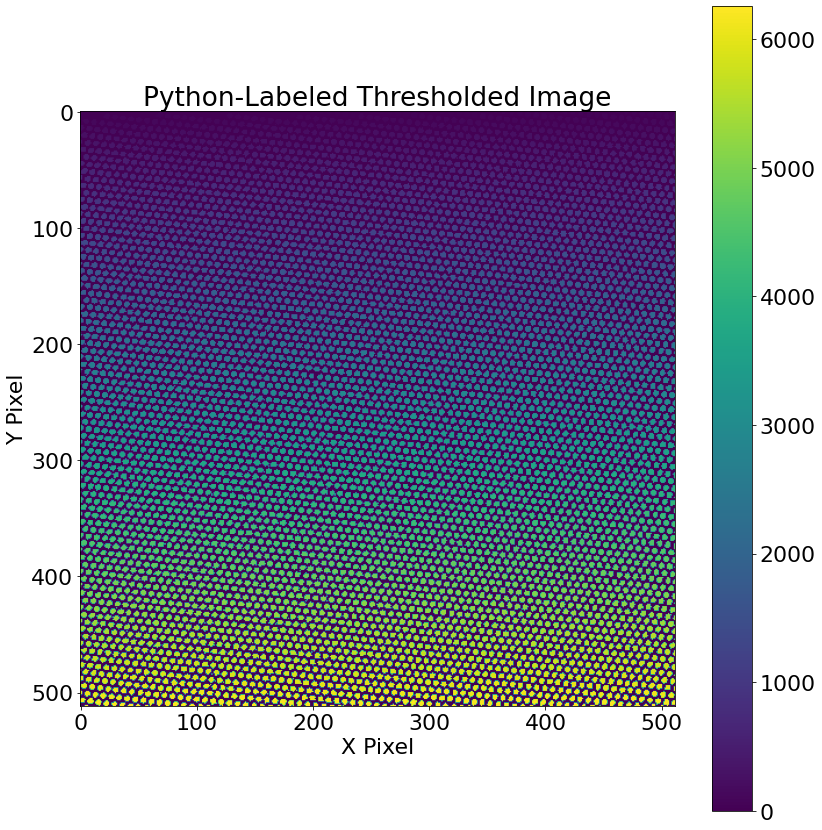

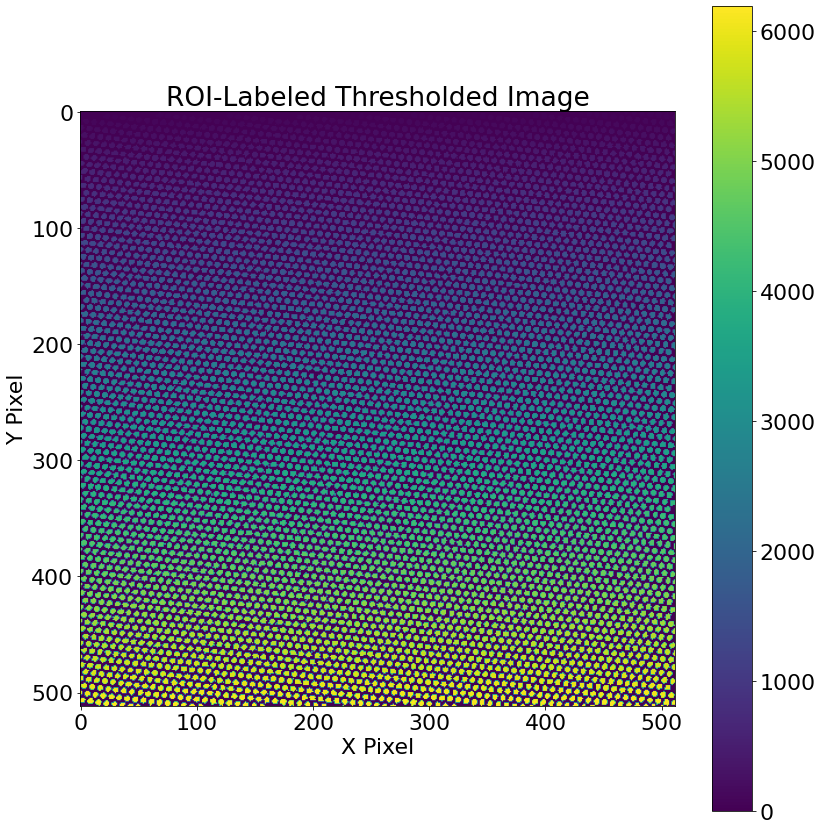

In [18]:
save_folder = file_extension + str(filename_load) + '/' 

plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 22})
plt.imshow(img_label)
plt.colorbar()
plt.title('Python-Labeled Thresholded Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.tight_layout()
plt.savefig(save_folder + 'Python-Labeled Thresholded Image.png')
plt.show()   

plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 22})
plt.imshow(img_label_mod)
plt.colorbar()
plt.title('ROI-Labeled Thresholded Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.tight_layout()
plt.savefig(save_folder + 'Reassigned Python Thresholded Image.png')
plt.show()

From here, we know that the ROI values in ‘img_label_mod’ match the ROI values from the imagej results data, saved in ‘df_sort’. Therefore any analysis done on the data can be mapped back to its original position.

In [19]:
#Create df's used for analysis functions
df = res_sort[['Mean', 'Slice', 'ROI']]
df_sort = df.sort_values(['ROI', 'Slice'], ascending = (True, True))




#### Example Application of Mapping Electrode Data: Quantifying Electrode Uniformity

Below I give a brief example of how powerful this mapping function can be. In experiments, it is often valuable to quantify the uniformity of the ECL response from the array. We measure this by sweeping the potential in cyclic voltammogram and mapping the potential each electrode surpasses a given intensity value. Ideally this distribution should be as narrow as possible, which indicates that each electrode has a uniform response. We define map_threshold() to perform this task.

In [22]:
#The first part of the function uses np.argmax() to determine the slice that the intensity surpasses a given input threshold.

def map_threshold(df_sort, threshold):
    '''Input dataframe with columns labeled 'Mean', 'Slice', 'ROI' 
    Output df with rows as ROI, Mean, Slice where threshold value occurs in each ROI'''

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    '''Determine thresholded frame for each ROI'''
    total_roi = df_sort.ROI.max()
    save = pd.DataFrame()
    for i in range(1, (total_roi + 1)): #6000+ ROI's
        
        current_roi = df_sort[df_sort['ROI'] == i] # identify single ROI
        mean_col = current_roi.Mean #select only intensity column.
        thresholded_frame = pd.DataFrame(current_roi.iloc[np.argmax(mean_col > threshold)]).T #info with thresholded frame. 
        
        save = pd.concat([save, thresholded_frame], axis = 0) #Output with thresholded info. #Slice info, ROI, intensity
    
    save.reset_index(inplace=True, drop=True)   
    
    
    
    #The second part of the function changes the mapped ROI value of ‘img_label_mod’ to the identified frame found above.

    map_threshold_slice = img_label_mod.copy()
    for i in range(1, int(np.max(save.ROI))+1): #Changes value of img_label_mod to slice # of threshold. 
        current_row = save.loc[save['ROI'] == i]
        
        roi_num = int(current_row['ROI'][i-1]) #int #since index increments, and is 1 behind iterator. 
        slice_num = int(current_row['Slice'][i-1]) #int
            
        #map slice
        map_threshold_slice = np.where(map_threshold_slice == roi_num, slice_num + 10000, map_threshold_slice) #Where True, yield x, otherwise yield y. 
        
    map_threshold_slice = map_threshold_slice - 10000 #Introduced offset to avoid changing    
    
    
    #Remove 0's, 1's from 'save'
    save['Slice'] = save['Slice'].replace([0 ,1], np.mean(save.Slice))
    
    
    
    #Given that the start of the camera recording and applied potential sweep is controlled with a trigger in Labview, 
    #converting slice number of potential (mV) is consistent.
    
    map_threshold_mV = map_threshold_slice * (6.31)
    save['mv'] = save.Slice.apply(lambda x: x*(6.31))
    
    #Lastly, we plot our results with imshow() to display the mapped image, 
    #and use seaborn to plot a histogram summarizing the results.
    
    plt.figure(figsize=(12,12))
    plt.rcParams['figure.dpi'] = 600 #needed to prevent pixelation of electrodes 
    plt.rcParams.update({'font.size': 22})
    plt.imshow(map_threshold_mV, cmap= 'jet_r', vmin = save.mv.min()) #Scales so that colorbar min = first threshold.
    plt.colorbar()
    plt.title('mV with Intensity >' + str(threshold) + ' Scaled to show variation\n')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.tight_layout()
    plt.savefig(save_folder + 'Potential (mV) with Intensity larger' + str(threshold) + ' Scaled to show variation'+ '.png')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.rcParams['figure.dpi'] = 300 #needed to prevent pixelation of electrodes     
    plt.rcParams.update({'font.size': 22})
    sns.distplot(save.mv, color = 'k', kde=False, bins = abs(int(save.mv.max() - save.mv.min()))) #1 bin per frame
    plt.xlabel('Potential (mV)')
    plt.ylabel('# of Electrodes')
    plt.title('Potential (mV) where Intensity > ' + str(threshold))
    plt.tight_layout()
    plt.savefig(save_folder + 'Potential (mV) where Intensity larger ' + str(threshold) + '_Histogram' + '.png')
    plt.show()

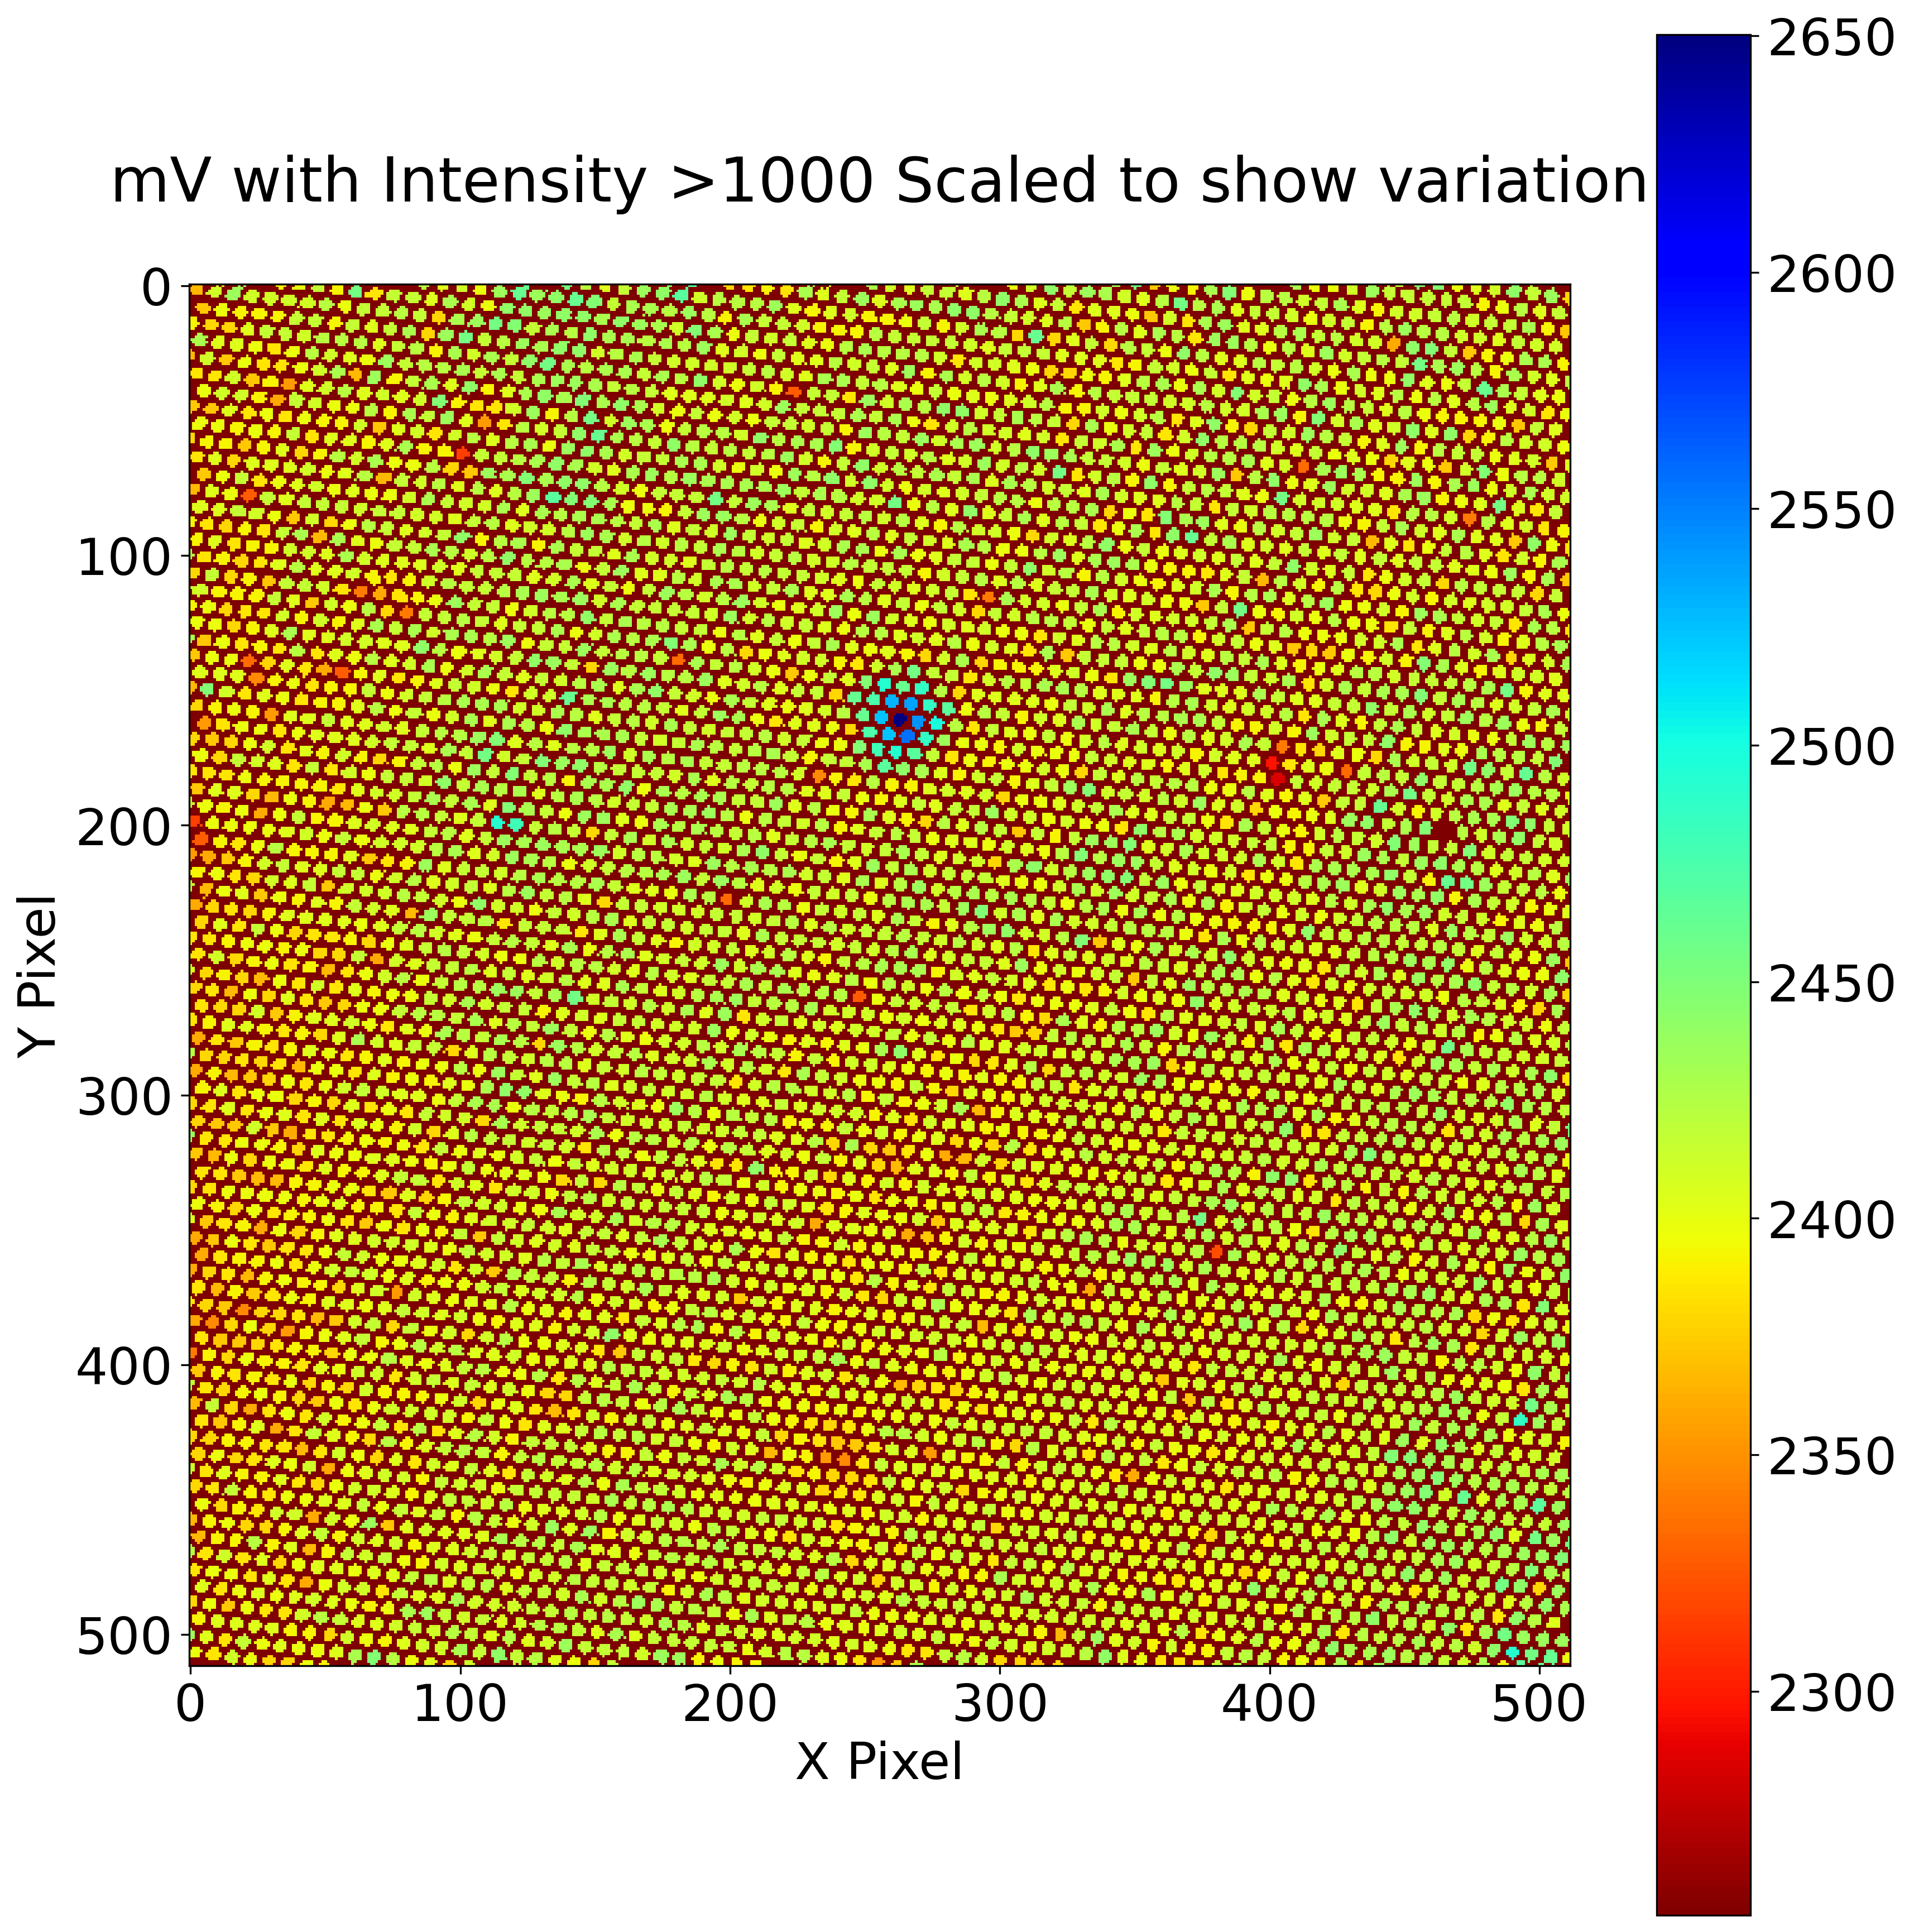

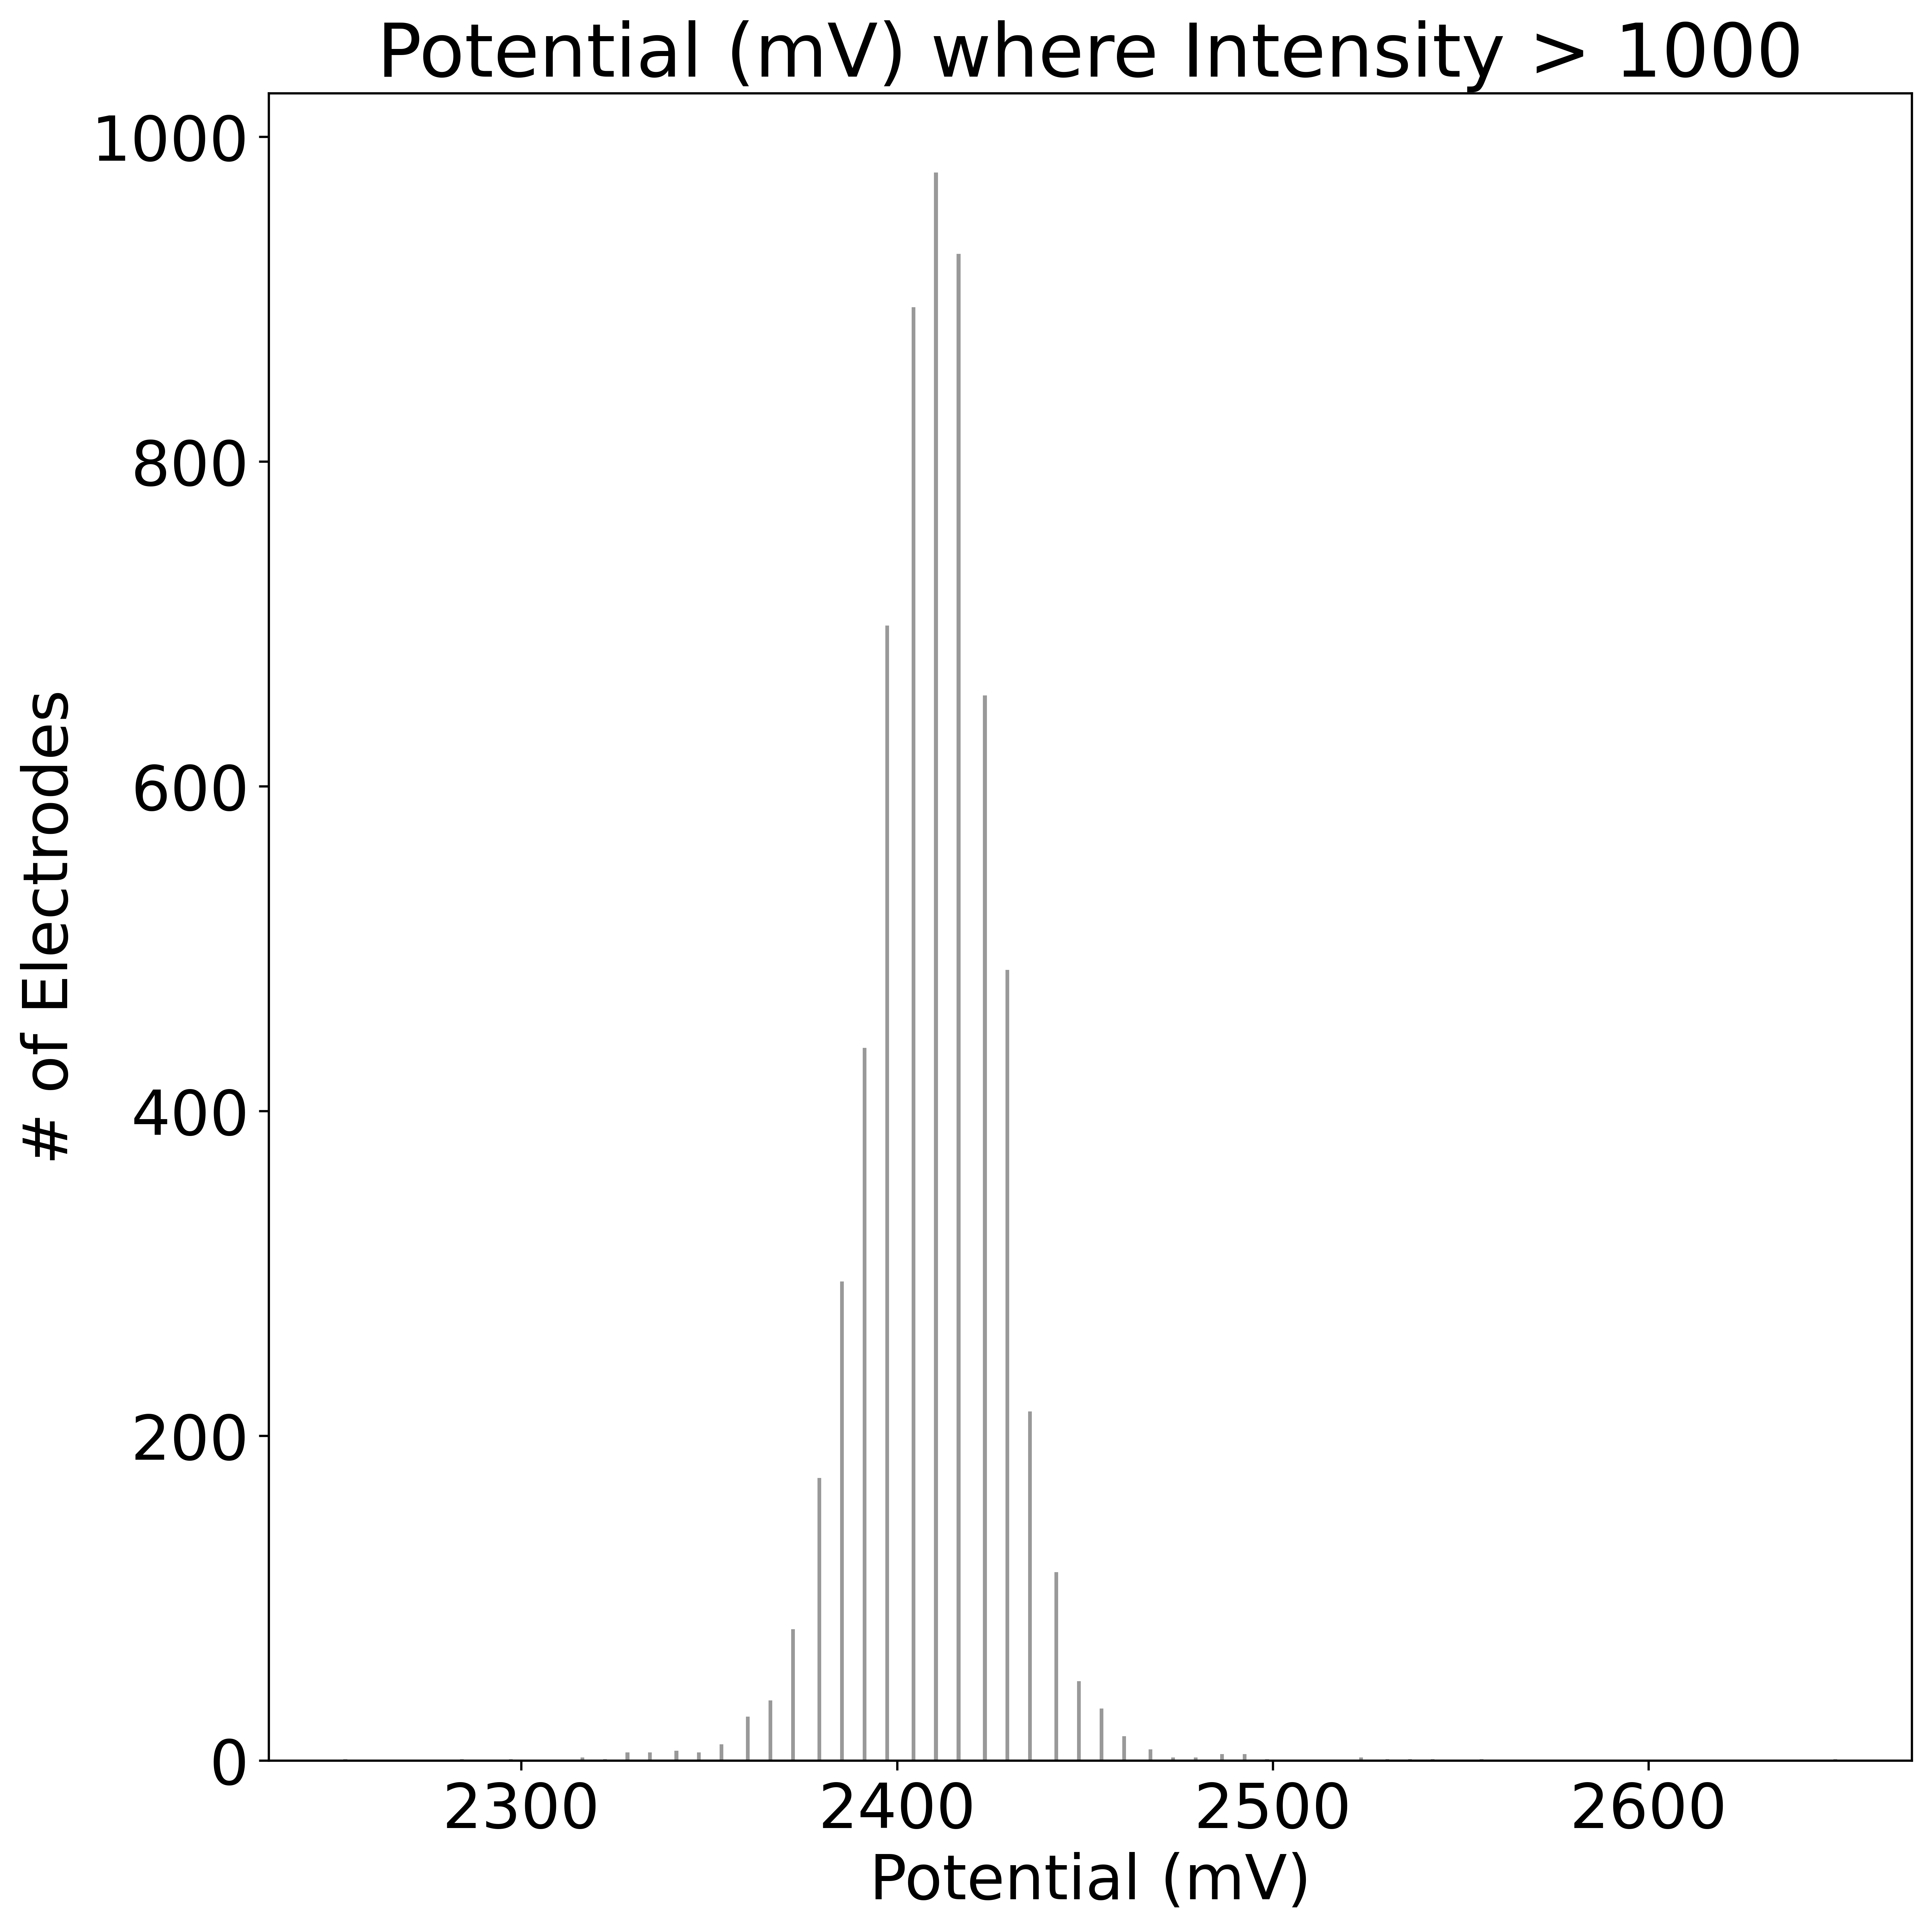

In [23]:
map_threshold(df_sort, 1000) #intensity

The first figure maps the potential (in mV) that each electrode surpasses a given raw intensity value. The response is roughly uniform, with a ~15 electrode cluster activating ~100-150 mV later than the bulk. The second figure plots a histogram to visualize this same distribution. 





   
### *Conclusion:*

While a straightforward application is shown here, this mapping function is extremely valuable for visualizing data generated with our ECL-output closed-bipolar microelectrode array. More specific use cases will become publicly available as our research is published.